In [1]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import skimage
import time

from scipy import ndimage

from tqdm.notebook import tqdm


import json
import datetime


import seaborn as sns
from PIL import ImageColor

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


# 1. Load Image and Preprocess

In [4]:
# Load in image, convert to gray scale, and Otsu's threshold
# image = cv2.imread('inferred_masks/inference_no_bees_new.png',0)
image = np.load("inferred_masks/pred_no_bees_new.npy")
print(image.shape)
thresh = cv2.threshold(image.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]



(2976, 4000)


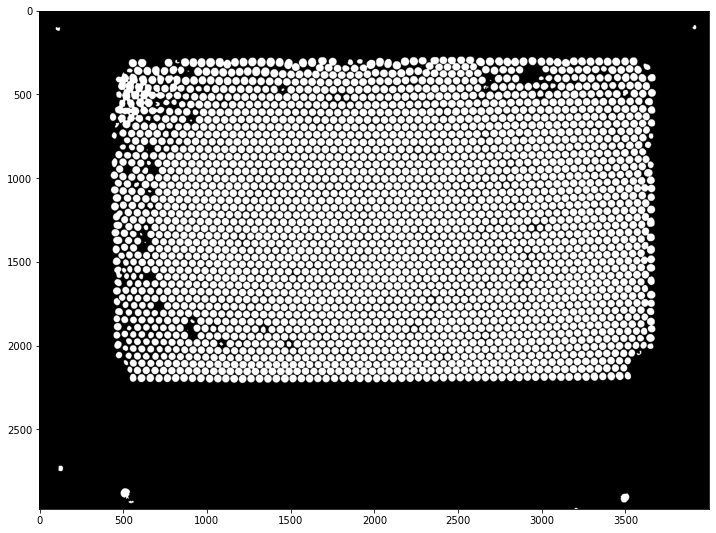

In [5]:
plt.figure(figsize = (12,12))
plt.imshow(thresh, cmap = 'gray')

# 2. Distance Map

(-0.5, 299.5, 0.0, 240.0)

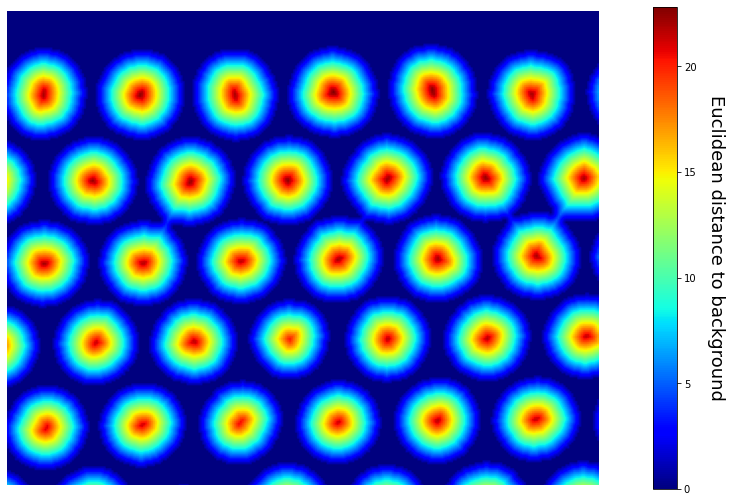

In [6]:
# Compute Euclidean distance from every binary pixel to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)

plt.figure(figsize = (12,12))
plt.imshow(distance_map.astype(np.float32)[2000:2300,1000:1300], cmap='jet')
cbar = plt.colorbar(fraction=0.036, pad=0.08)

cbar.ax.set_ylabel('Euclidean distance to background', rotation=270, fontsize = 18)
cbar.ax.yaxis.set_label_coords(3,0.5)
plt.ylim(0,240)
plt.axis('off')
# plt.savefig("plots/EDT_cells.png", bbox_inches='tight')



In [7]:
# local_max = peak_local_max(distance_map, indices = False, min_distance=30, labels=thresh)
local_max_indices = peak_local_max(distance_map, min_distance=30, labels=thresh)


In [8]:
temp = np.zeros_like(distance_map)
temp[tuple(local_max_indices.T)] = 1


In [9]:
local_max_indices.shape

(2772, 2)

## 2.1 Show peaks

In [10]:
temp_image = np.zeros_like(image).astype('uint8')
temp_image.shape

# find peaks

"""
min_distance : int, optional
    The minimal allowed distance separating peaks. To find the
    maximum number of peaks, use `min_distance=1`.
    
checked distance between cells. I would say 30-40
""" 
local_max = peak_local_max(distance_map, min_distance=30, labels=thresh)

# for i in tqdm(zip(*np.where(local_max != 0))):
    
for i in tqdm(local_max):

    cv2.circle(temp_image, (int(i[1]), int(i[0])), 4,  [255, 0, 255], thickness=2)


  0%|          | 0/2772 [00:00<?, ?it/s]

In [11]:
import json 

path_label_classes = "/srv/data/ivan_matoshchuk_new/honeybee_cells_segmentation/data/label_classes.json"

with open(path_label_classes, "r") as f:
    label_classes = json.load(f)
    
# prepare labels and colors
cmap = {}
labels = {}
labels_hex = {}
labels_rgb = {}

labels[0] = "background" 
for i, alpha in zip(label_classes, np.linspace(0.9, 1,len(label_classes))):
    color = ImageColor.getcolor(i['color'],"RGB")
    
    cmap[i["png_index"]] = [i/255 for i in color] + [alpha]
    labels[i["png_index"]] = i["name"]
    
    labels_hex[i['png_index']] = '#%02x%02x%02x' % (color[0], color[1], color[2])
    
    labels_rgb[i['png_index']] = color
        
cmap[0] = [1,1,1,1]


(-0.5, 3999.5, 2975.5, -0.5)

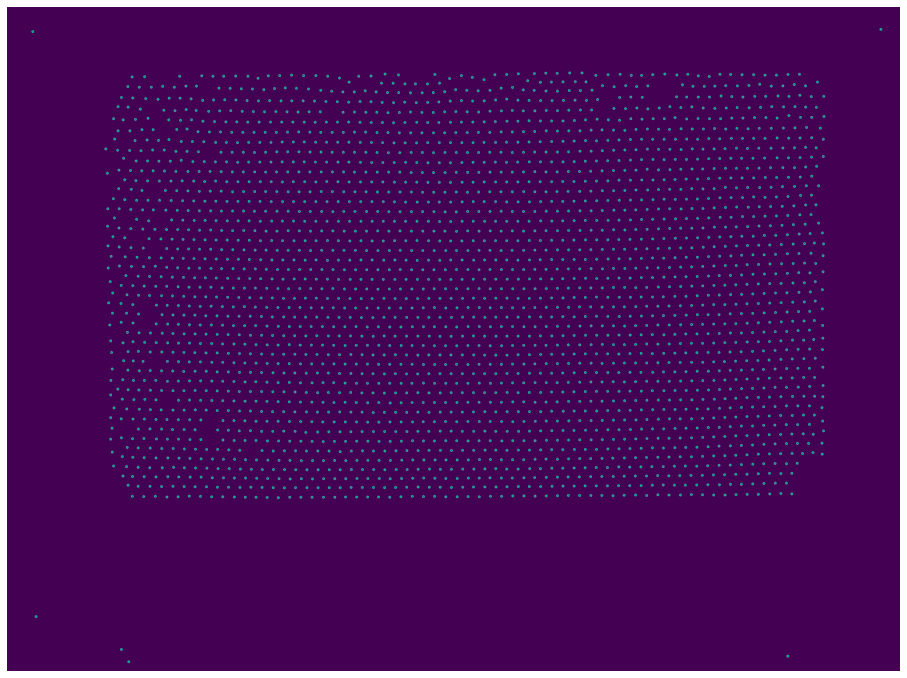

In [12]:
plt.figure(figsize = (16,16))
plt.imshow(temp_image)
plt.axis("off")
#plt.savefig("plots/edt_dots_full_image.png", bbox_inches='tight')


# 3. Count number of cells for each category

In [13]:
labels = {0: 'background',
 1: 'bees',
 2: 'empty_cell',
 3: 'open_brood',
 4: 'open_honey',
 5: 'capped_honey',
 6: 'capped_brood',
 7: 'pollen',
 8: 'bee_in_cell'}

ground_truth = {3: 120,
               4: 155,
               5: 54,
               6: 0,
               7: 40,
               8: 1}

In [14]:
image.shape

(2976, 4000)

In [15]:
sub_image = image.copy()
sub_image = sub_image[200:2300,300:3800]


In [22]:
start = time.time()
output_edt = {}
indices_of_classes = {}

total = 0
for i in np.unique(sub_image)[1:]:
    
    temp = sub_image.astype('uint8').copy()
    
    temp[temp != i] = 0
    
    thresh = cv2.threshold(temp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Compute Euclidean distance from every binary pixel to the nearest zero pixel then find peaks
    distance_map = ndimage.distance_transform_edt(thresh)
    
    # if i == 3 or i == 5:
    #     "if open brood or capped honey we are less strict"
    #     local_max = peak_local_max(distance_map, min_distance=35, labels=thresh)
    # else:
    
    local_max = peak_local_max(distance_map,  min_distance=35, labels=thresh)

    print(labels[i],"-> Prediction: ", local_max.shape[0]," || Ground Truth: ", ground_truth.get(i,"No Information"))
    total += local_max.shape[0]
    output_edt[labels[i]] = local_max.shape[0]
    indices_of_classes[i] = local_max
    
print(total)
print(time.time() - start)

empty_cell -> Prediction:  2361  || Ground Truth:  No Information
2361
0.9274585247039795


In [17]:
output_edt

{'empty_cell': 2361,
 'open_brood': 135,
 'open_honey': 154,
 'capped_honey': 47,
 'pollen': 46,
 'bee_in_cell': 2}

In [23]:
import matplotlib.cm as cm
thresh = cv2.threshold(sub_image.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


In [24]:
labels_mapping = {0:'background',
 1: 'bees',
 2: 'empty cell',
 3: 'open brood (larva)',
 4: 'open honey (nectar)',
 5: 'capped honey',
 6: 'capped brood (pupa)',
 7: 'pollen',
 8: 'bee-in-cell'}

In [25]:
patches =[mpatches.Patch(color=cmap[i],label=labels_mapping[i]) for i in [2,3,4,5,7,8]]


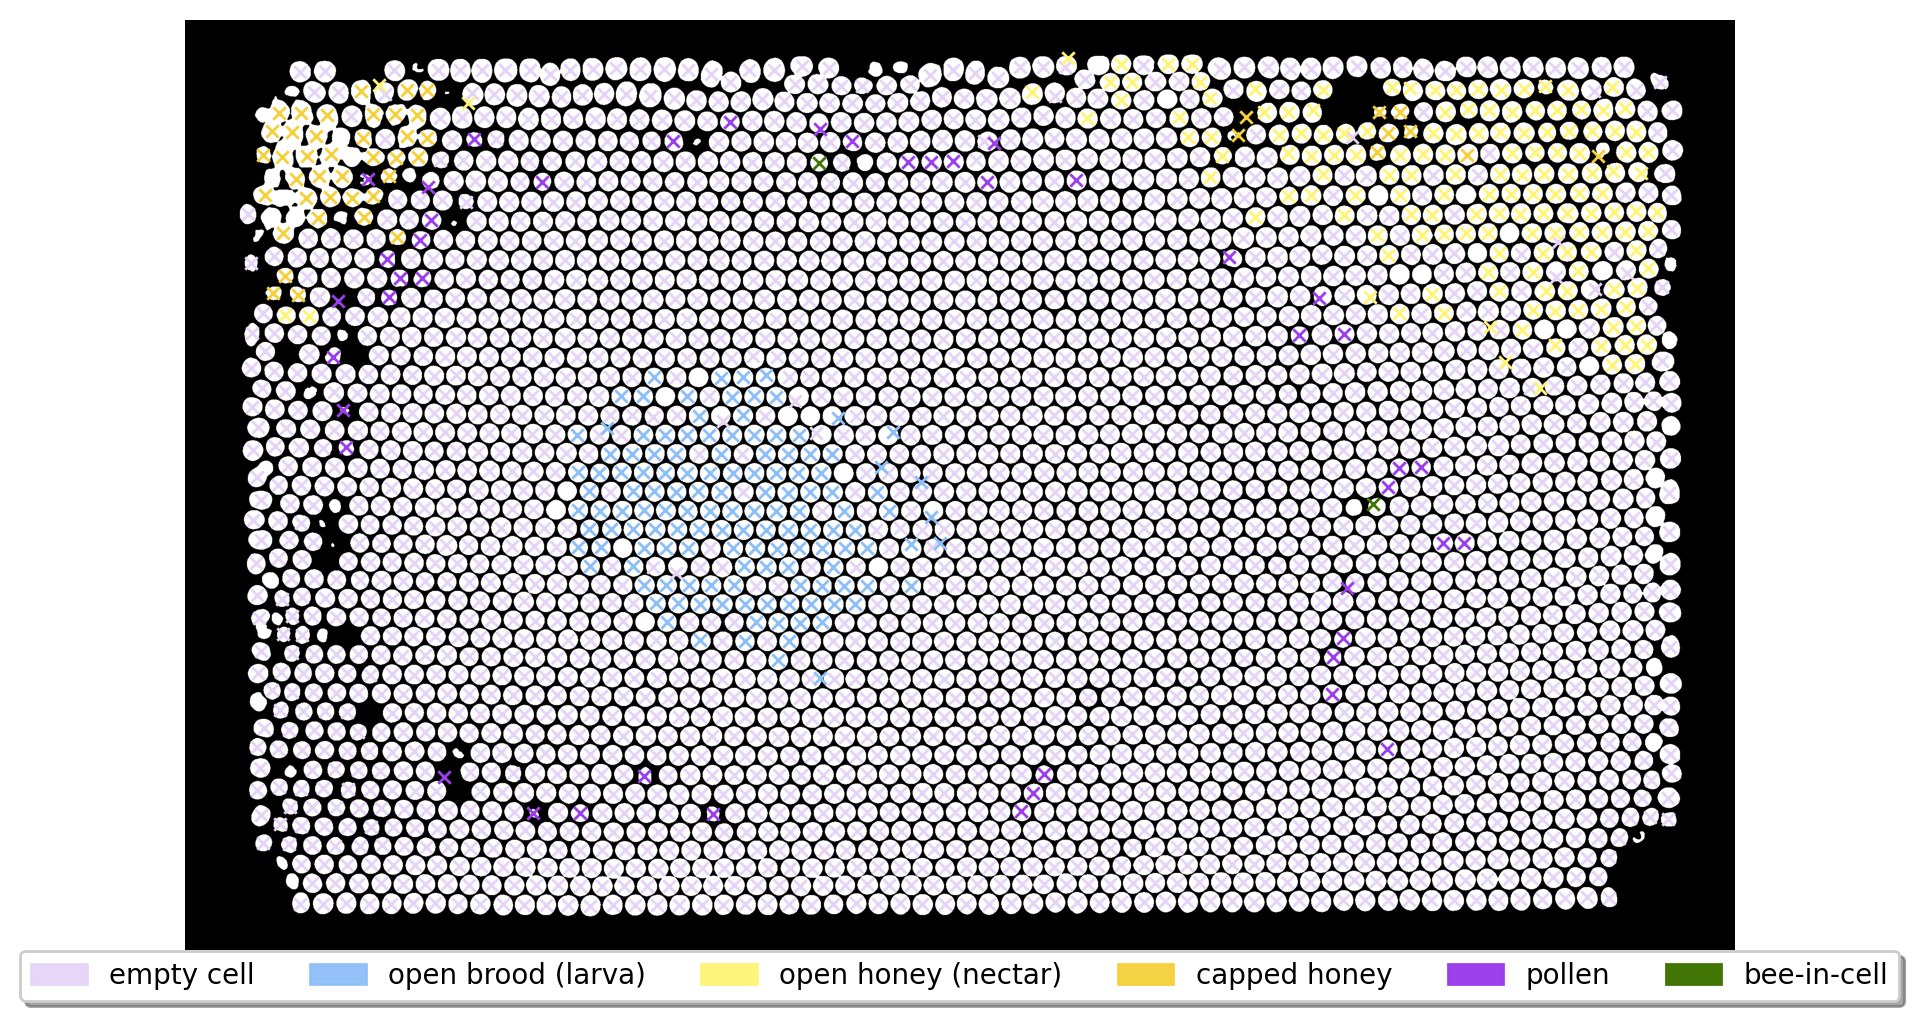

In [28]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
#plt.imshow(thresh, cmap=cm.gray)#"gray")
plt.imshow(thresh, cmap = 'gray')
# plt.imshow(rgb_img)

for cat, indices in indices_of_classes.items():
    indices_tuple = tuple(indices.T)
    sns.scatterplot(x=indices_tuple[1], y=indices_tuple[0], color=labels_hex[cat], marker="x", s=20, linewidth = 1)#, transform = rot) labels_hex[cat]
plt.axis('off')
lgd = plt.legend(handles=patches, loc="lower center", bbox_to_anchor=(0.5, -0.07), ncol=6, fancybox=True, shadow=True, fontsize = 10)
plt.savefig("plots/edt_dots_full_image_colored_cropped.png", bbox_inches='tight')



plt.show()

# 4. Circle Hough Transform

## 4.1 Canny edge detection

In [7]:
thresh = cv2.threshold(image.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cell_borders = skimage.feature.canny(thresh)


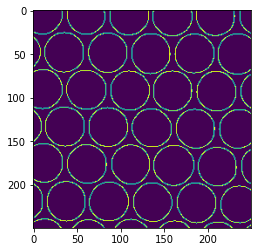

In [8]:
plt.imshow(cell_borders[1000:1250, 1000:1250])

In [10]:
radius = 48.0 / 2.0
radii = np.arange(int(radius * 0.75), int(radius * 1.25))

output_cht = {}
start = time.time()
total = 0
for i in np.unique(image)[1:]:
    
    temp = image.astype('uint8').copy()
    temp[temp != i] = 0
    
    thresh = cv2.threshold(temp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    cell_borders = skimage.feature.canny(thresh)
    hough = skimage.transform.hough_circle(cell_borders, radius=radii)
    
    accum, cx, cy, rad = skimage.transform.hough_circle_peaks(hough,
                                                              radii=radii,
                                                              min_xdistance=int(1.5 * radius), min_ydistance=int(1.5 * radius), normalize=True)
    
    print(labels[i],"-> Prediction: ", cx.shape[0]," || Ground Truth: ", ground_truth.get(i,"No Information"))
    total += cx.shape[0]
    output_cht[labels[i]] = cx.shape[0]
    
print(total)
print(time.time() - start)

empty_cell -> Prediction:  2398  || Ground Truth:  No Information
open_brood -> Prediction:  167  || Ground Truth:  120
open_honey -> Prediction:  176  || Ground Truth:  155
capped_honey -> Prediction:  53  || Ground Truth:  54
pollen -> Prediction:  43  || Ground Truth:  40
bee_in_cell -> Prediction:  4  || Ground Truth:  1
2841
31.153563499450684


In [68]:
radii = np.arange(int(radius * 0.75), int(radius * 1.25))
hough = skimage.transform.hough_circle(cell_borders, radius=radii)
accum, cx, cy, rad = skimage.transform.hough_circle_peaks(hough,
                                                          radii=radii,
                                                          min_xdistance=int(1.5 * radius), min_ydistance=int(1.5 * radius), normalize=True)

In [78]:
cx.shape

(2754,)

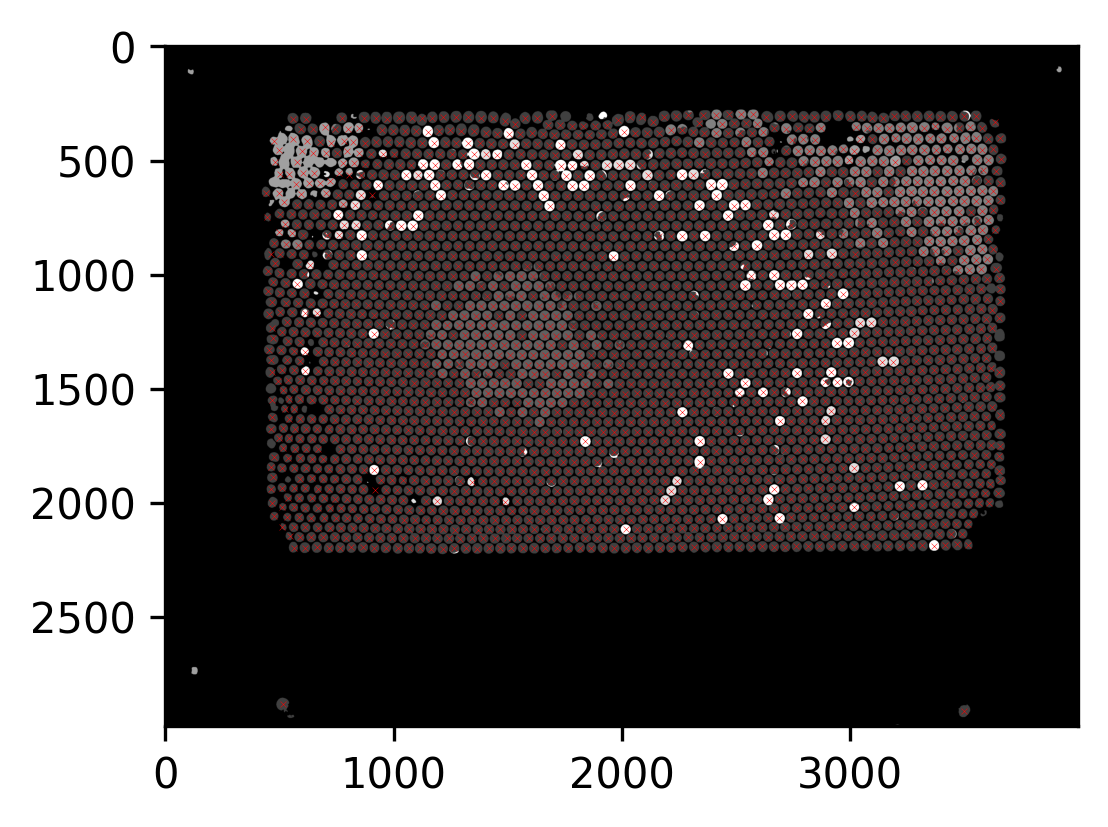

In [71]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
plt.imshow(image, cmap="gray")
sns.scatterplot(x=cx, y=cy, color="red", marker="x", s=2)
plt.show()

In [248]:
def get_class_count(pred: np.ndarray, category: int or None = None, verbose: bool = False) -> dict:
    
    output = {}
    
    for i in tqdm(np.unique(pred)[1:]):
        
        if category is not None and i != category:
            continue

        temp = image.copy()

        temp[temp != i] = 0

        thresh = cv2.threshold(temp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Compute Euclidean distance from every binary pixel to the nearest zero pixel then find peaks
        distance_map = ndimage.distance_transform_edt(thresh)

        if i == 3 or i == 5:
            "if open brood or capped honey we are less strict"
            local_max = peak_local_max(distance_map, min_distance=30, labels=thresh)
        else:
            local_max = peak_local_max(distance_map,  min_distance=35, labels=thresh)
            
        output[labels[i]] = local_max.shape[0]
        
        if verbose:
            print(labels[i],"-> Prediction: ", local_max.shape[0])
            # print(labels[i],"-> Prediction: ", local_max.shape[0]," || Ground Truth: ", ground_truth.get(i,"No Information"))
        
    return output

In [249]:
image = cv2.imread('pred_no-color.png',0)

class_count = get_class_count(image)

  0%|          | 0/7 [00:00<?, ?it/s]

In [250]:
class_count

{'empty_cell': 2268,
 'open_brood': 49,
 'open_honey': 85,
 'capped_honey': 26,
 'capped_brood': 2,
 'pollen': 29,
 'bee_in_cell': 87}

In [11]:
labels_reversed = {v:k for k,v in labels.items()}


In [12]:
output_edt_df = pd.DataFrame(output_edt, index = ["cell_count_EDT"]).T
output_cht_df = pd.DataFrame(output_cht, index = ["cell_count_CHT"]).T


In [13]:
output_df = pd.concat([output_edt_df, output_cht_df], axis = 1).sort_values(by = "cell_count_EDT").iloc[1:,:]
output_df

cell_count_EDT  cell_count_CHT
pollen                    46              43
capped_honey              50              53
open_brood               135             167
open_honey               154             176
empty_cell              2363            2398

In [14]:
labels_mapping = {0:'background',
 1: 'bees',
 2: 'empty cell',
 3: 'open brood (larva)',
 4: 'open honey (nectar)',
 5: 'capped honey',
 6: 'capped brood (pupa)',
 7: 'pollen',
 8: 'bee-in-cell'}



In [15]:
output_df.index = output_df.index.map(labels_reversed).map(labels_mapping)

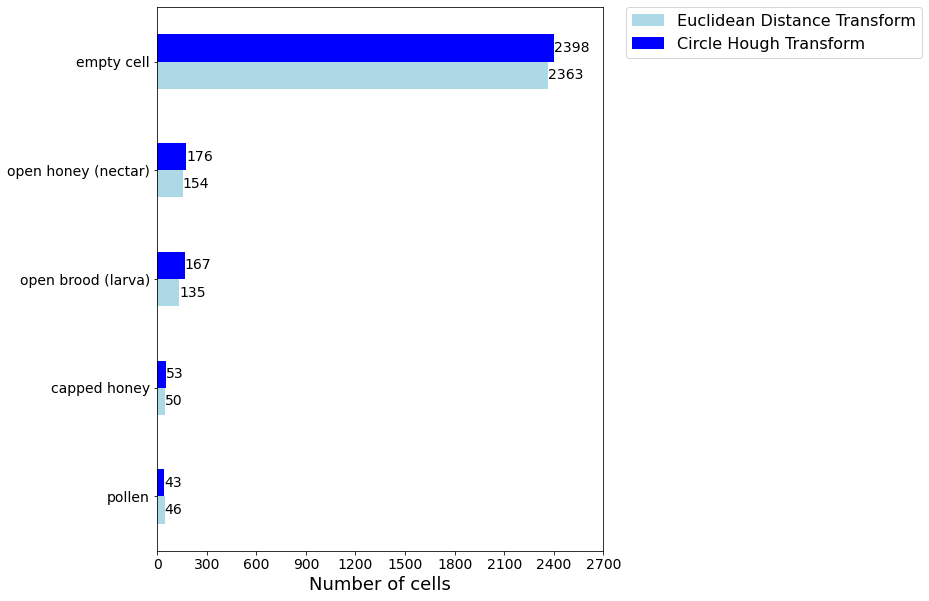

In [16]:
ax = output_df.rename(columns = {"cell_count_EDT":"Euclidean Distance Transform", "cell_count_CHT":"Circle Hough Transform"})\
              .plot(kind = 'barh', figsize = (8,10), color = ["lightblue","blue"], fontsize = 14)

for bars in ax.containers:
    ax.bar_label(bars, label_type='edge', fontsize = 14)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)

plt.xlabel("Number of cells", fontsize = 18)
_ = plt.xticks(np.arange(0, total, 300))

plt.savefig("plots/cell_count_edt_cht_comparison.png", bbox_inches='tight')
plt.show()

In [157]:
output_df = pd.concat([output_edt_df, output_cht_df], axis = 1)

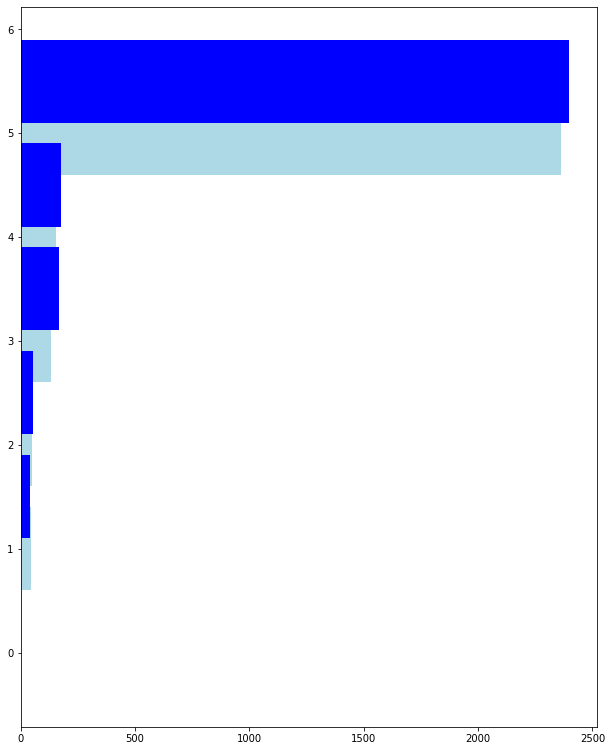

In [166]:
fig = plt.figure(figsize = (8,10))
ax = fig.add_axes([0,0,1,1])

#pd.concat([output_edt_df, output_cht_df], axis = 1).sort_values(by = "cell_count_EDT").plot(kind = 'barh')

output_df = output_df.sort_values(by = "cell_count_EDT")

ax.barh(np.arange(6), output_df.iloc[:,0], color = 'lightblue')
ax.barh(np.arange(6) + 0.5, output_df.iloc[:,1], color = 'b')

plt.show()

<BarContainer object of 7 artists>

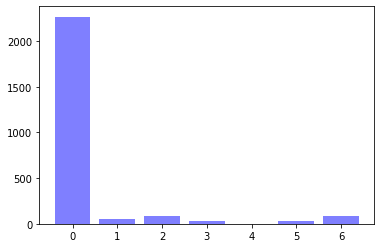

In [283]:
ax = plt.subplot(111)

ax.bar(np.arange(0,7,1), output_df["count"].values, color = 'blue', alpha = 0.5)



# N. Infer Time-Line (from David)

In [1]:
import pandas

In [2]:
import pickle

with open("inferred_masks/ivan_timeline_df.pickle", "rb") as f:
    all_results_df = pickle.load(f)
    

In [7]:
all_results_df.head(10)

cam_id        date                        timestamp         label  \
0          0  2019-07-23 2019-07-23 14:44:53.899085+00:00    background   
3169       0  2019-07-23 2019-07-23 15:14:05.950291+00:00          bees   
3168       0  2019-07-23 2019-07-23 15:14:05.950291+00:00    background   
3149       0  2019-07-23 2019-07-23 15:08:32.226094+00:00   bee_in_cell   
3148       0  2019-07-23 2019-07-23 15:08:32.226094+00:00        pollen   
3147       0  2019-07-23 2019-07-23 15:08:32.226094+00:00  capped_brood   
3146       0  2019-07-23 2019-07-23 15:08:32.226094+00:00  capped_honey   
3145       0  2019-07-23 2019-07-23 15:08:32.226094+00:00    open_honey   
3170       0  2019-07-23 2019-07-23 15:14:05.950291+00:00    empty_cell   
3144       0  2019-07-23 2019-07-23 15:08:32.226094+00:00    open_brood   

      n_pixels  year_hour  hour  
0      6964907          0    14  
3169   3652045          0    15  
3168   6916047          0    15  
3149    108676          0    15  
3148      3910          0    15  
3147         0          0    15  
3146     12144          0    15  
3145     61086          0    15  
3170   1181652          0    15  
3144     26418          0    15

In [9]:
all_results_df["timestamp"].nunique()

334202

In [19]:
3939255 - 3007818

931437

In [10]:
import pandas as pd
test = pd.read_parquet("inferred_masks/ivan_timeline_df.parquet")
test.shape

(3939255, 7)

In [22]:
test.head()

cam_id        date                         timestamp       label  \
index                                                                       
0             0  2019-07-23  2019-07-23T14:44:53.899085+00:00  background   
1966044       1  2019-07-23  2019-07-23T15:11:20.506444+00:00  open_brood   
1966043       1  2019-07-23  2019-07-23T15:11:20.506444+00:00  empty_cell   
1966042       1  2019-07-23  2019-07-23T15:11:20.506444+00:00        bees   
1966041       1  2019-07-23  2019-07-23T15:11:20.506444+00:00  background   

         n_pixels  year_hour  hour  
index                               
0         6868907          0    14  
1966044     19248          0    15  
1966043   1047822          0    15  
1966042   4241354          0    15  
1966041   6410728          0    15

In [23]:
test["date"] = pd.to_datetime(test["date"])
test["timestamp"] = pd.to_datetime(test["timestamp"])


In [41]:
all_results_df = test.copy()

In [115]:
path_label_classes = "/srv/data/ivan_matoshchuk_new/honeybee_cells_segmentation/data/label_classes.json"

with open(path_label_classes, "r") as f:
    label_classes = json.load(f)
    
# prepare labels and colors
cmap = {}
labels = {}
labels_hex = {}

labels[0] = "background" 
for i, alpha in zip(label_classes, np.linspace(0.5, 1,len(label_classes))):
    color = ImageColor.getcolor(i['color'],"RGB")
    
    cmap[i["png_index"]] = [i/255 for i in color] + [alpha]
    labels[i["png_index"]] = i["name"]
    
    labels_hex[i["name"]] = '#%02x%02x%02x' % (color[0], color[1], color[2])
    
cmap[0] = [1,1,1,1]


In [111]:
labels_hex

{'bees': '#7cb43c',
 'empty_cell': '#e5d4f6',
 'open_brood': '#8cbef8',
 'open_honey': '#fff474',
 'capped_honey': '#f5d03a',
 'capped_brood': '#1e5faa',
 'pollen': '#9c3eeb',
 'bee_in_cell': '#417505'}

In [97]:
rgb_code = (124, 180, 60)
hex_color = '#%02x%02x%02x' % (rgb_code[0], rgb_code[1], rgb_code[2])
hex_color

'#7cb43c'

In [118]:

patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]


In [124]:
labels_mapping = {0:'background',
 1: 'bees',
 2: 'empty cell',
 "open_brood": 'open brood (larva)',
 "open_honey": 'open honey (nectar)',
 "capped_honey": 'capped honey',
 "capped_brood": 'capped brood (pupa)',
 "pollen": 'pollen',
 "bee_in_cell": 'bee-in-cell'}

In [69]:
min_ts = 0.1

In [71]:
min_ts = all_results_df.date.min()

In [78]:
plt.style.use('default')


In [125]:
plot_df.columns[final_indices].map(labels_mapping)

Index(['bee-in-cell', 'capped brood (pupa)', 'capped honey',
       'open brood (larva)', 'open honey (nectar)', 'pollen'],
      dtype='object', name='label')

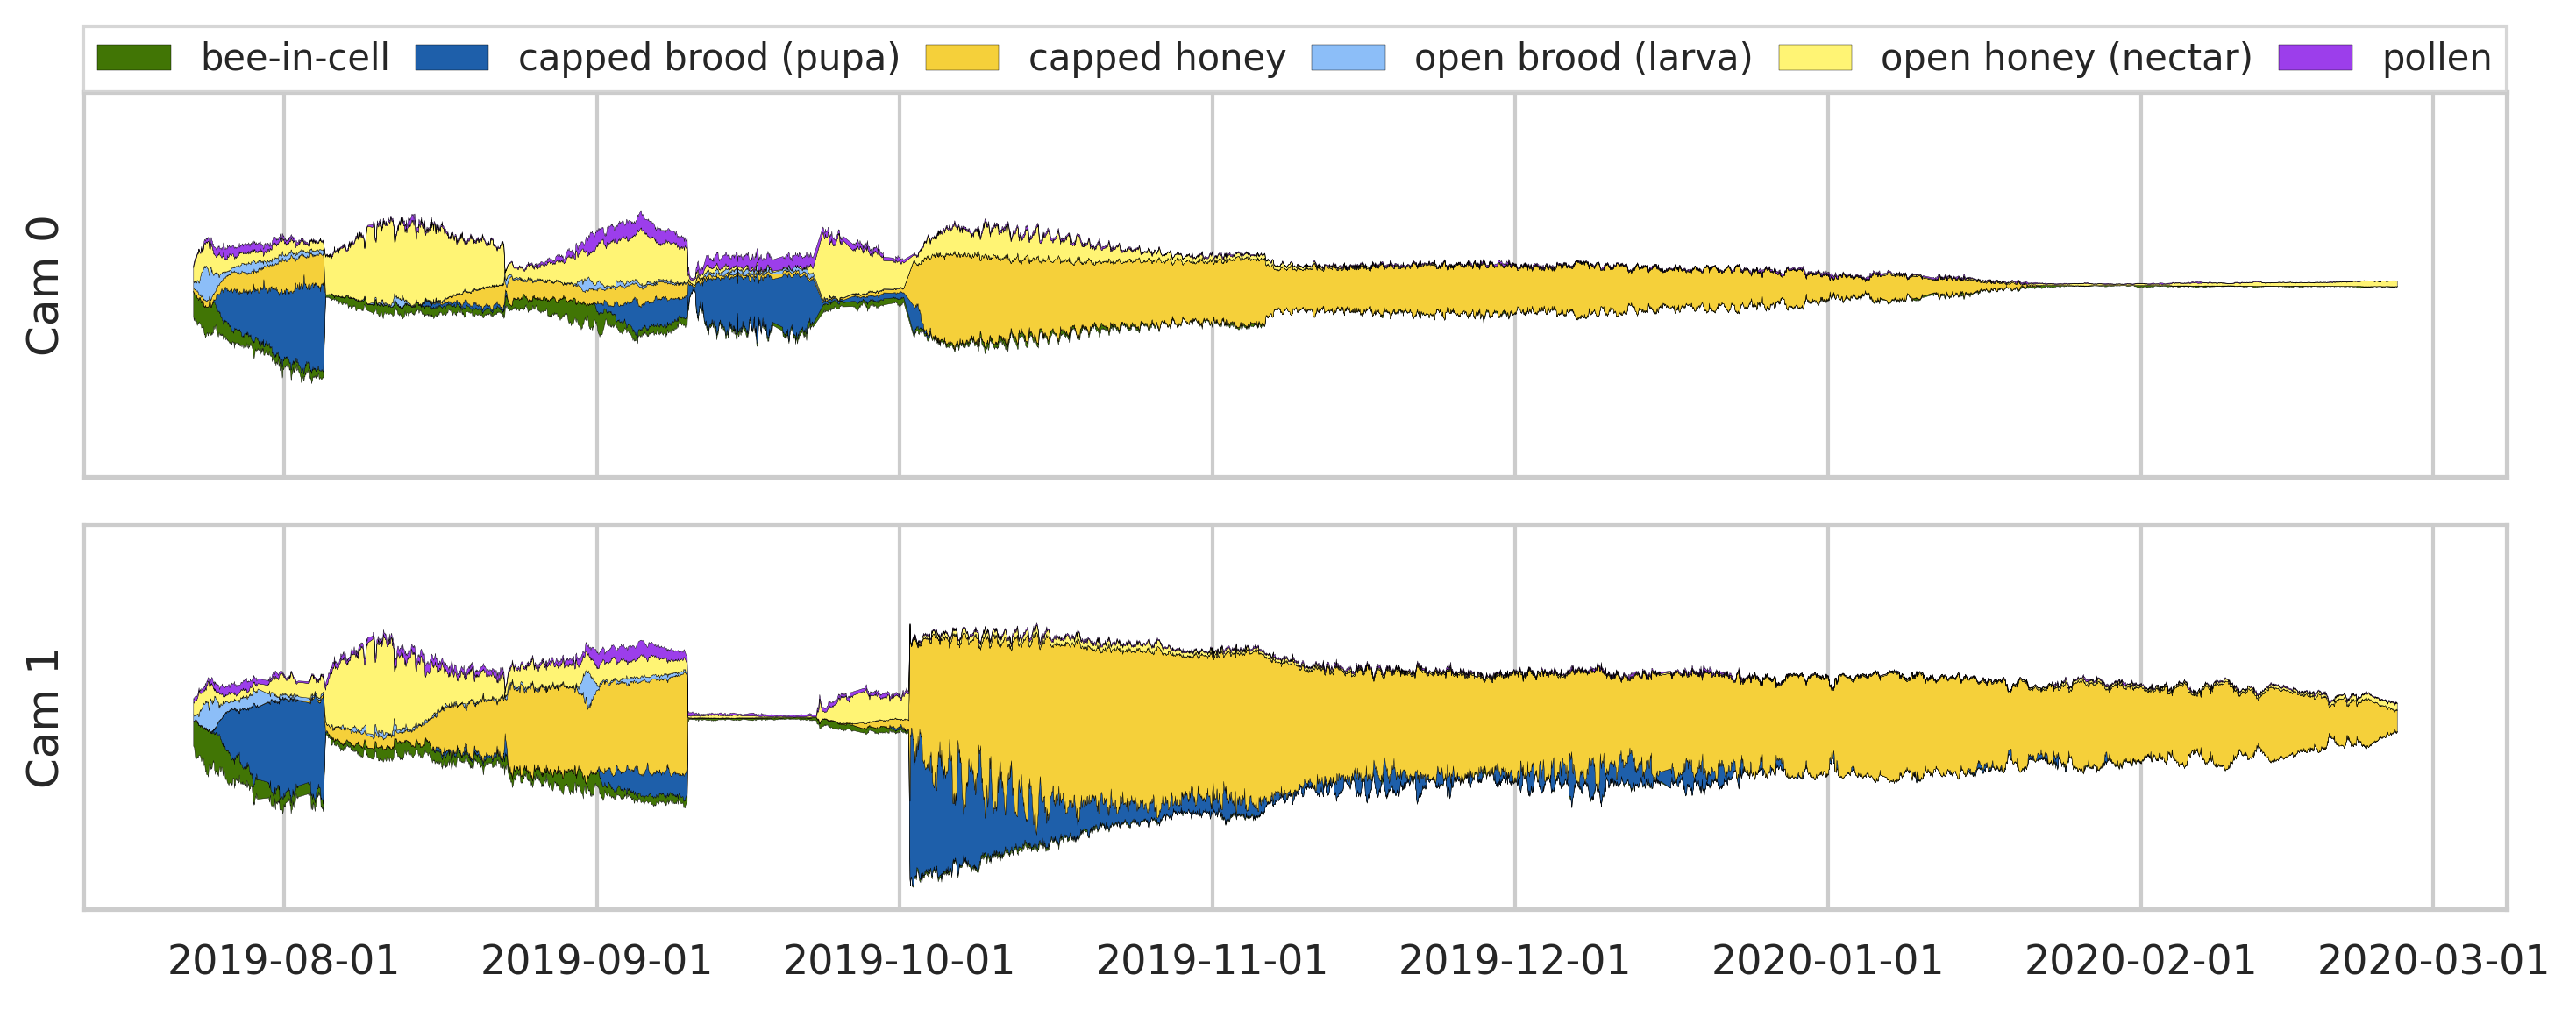

In [133]:
sns.set_theme(style="whitegrid", palette="deep")

fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True, dpi=300)
for cam_id, ax in zip(range(2), axes):
    plot_df = all_results_df.copy()
    plot_df = plot_df[plot_df.cam_id == cam_id]
    plot_df = plot_df[plot_df.label != "background"]
    #plot_df = plot_df[plot_df.label != "empty_cell"]
    plot_df = plot_df[plot_df.label != "bees"]
    #plot_df = plot_df[plot_df.label != "bees"]

    labels = list(sorted(plot_df.label.unique()))
    n_labels = len(labels)

    plot_df = plot_df.pivot_table(index=["year_hour", "label"], values=["n_pixels"], aggfunc=np.median)
    plot_df = plot_df.reset_index(level=(0, 1))
    plot_df = plot_df.fillna(0.0)
    plot_df = plot_df.pivot_table(index="year_hour", columns="label", values="n_pixels", aggfunc=np.median)
    plot_df = plot_df.fillna(0.0)


    values = plot_df.values.T
    values /= np.sum(values, axis=0)
    final_indices = [i for i in range(len(labels)) if labels[i] != "empty_cell"]
    values = values[final_indices, :]

    X = [min_ts + datetime.timedelta(hours=h) for h in plot_df.index]
    ax.stackplot(X, values, labels=plot_df.columns[final_indices].map(labels_mapping), colors = plot_df.columns[final_indices].map(labels_hex),
                 baseline="wiggle",
                 edgecolor="black", linewidth=0.1)
    #sns.kdeplot(x="year_hour", y="n_pixels", hue="label", data=plot_df,
    #            multiple="fill", ax=ax)
    #plt.semilogy()
    ax.set_ylim(-0.6, 0.6)
    
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    fig.canvas.draw()
    #for tl in ax.get_xticklabels():
    #    tl.set_rotation(30)
    ax.get_yaxis().set_visible(True)
    ax.set_ylabel(f"Cam {cam_id}")
    ax.get_yaxis().set_ticks([])
    
axes[0].legend(loc="lower left", bbox_to_anchor=(0.0, 1.0, 1, 0.2),
          mode="expand", borderaxespad=0,
          ncol=6, fancybox=False, shadow=False, fontsize = 10)
plt.tight_layout()
plt.savefig("plots/inference_timeline.png", bbox_inches='tight')
plt.show()